# Imports

In [112]:
import os
import numpy as np
from utils import utils
from utils import plotting
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from keras import optimizers
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt

# Output Class Setup

In [113]:
# encodings for labels in dataset
classes = ['squats', 'lunges', 'bicep_curls', 'situps', 
        'pushups', 'tricep_extensions', 'dumbbell_rows', 
        'jumping_jacks', 'dumbbell_shoulder_press', 
        'lateral_shoulder_raises']
d={}
for i,ex in enumerate(classes):
    d[ex] = i
d

{'squats': 0,
 'lunges': 1,
 'bicep_curls': 2,
 'situps': 3,
 'pushups': 4,
 'tricep_extensions': 5,
 'dumbbell_rows': 6,
 'jumping_jacks': 7,
 'dumbbell_shoulder_press': 8,
 'lateral_shoulder_raises': 9}

# Data Prep

In [114]:
def prepare_dataset(files, data_path):
    """
    Prepare the dataset using the files provided
    """
    from tqdm import tqdm

    df = pd.DataFrame()
    
    for w_id in tqdm(files):
        data_dir = os.path.join(data_path, w_id)
        t = utils.load_modality(os.path.join(data_dir, w_id + '_pose_2d.npy'))
        t2_frame = t.transpose(1,0,2).reshape(-1,38)
        
        # Creating nparray for ylabels
        y = []
        labels = utils.load_labels(os.path.join(data_dir, w_id + '_labels.csv'))
        for label in tqdm(labels):
            f1, f2, rep, lbl = label
            for frame in range(f1, f2+1):
                y.append([frame, d[lbl]])
        y = np.array(y)
        y_df = pd.DataFrame(y)

        # Frame appears twice. Once at the beginning (index 0) and once at pos 19. We don't need the second one.
        t2_df=pd.DataFrame(t2_frame).drop(19, axis=1)
        # Removing noise from data 
        # We will only retain the rows in the dataframe for which we have labels available.
        # Achieved with inner join
        df = pd.concat([df,t2_df.merge(y_df, how='inner', on=0)])
    return df

## Building test/train files

In [111]:
train_files = ['01', '02', '03', '04', '06', '07', '08', '16', 
               '17', '18', '14', '15', '19', '20', '12', '13']
train_file_names = list(map(lambda x : 'w' + x, train_files))
test_files = ['05', '09', '10', '11']
test_file_names = list(map(lambda x : 'w' + x, test_files))
val_files = ['00']
val_file_names = list(map(lambda x : 'w' + x, val_files))
data_path = 'data/mm-fit/'

train_df = prepare_dataset(train_file_names, data_path)
test_df = prepare_dataset(test_file_names, data_path)
val_df = prepare_dataset(val_file_names, data_path)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

NameError: name 'prepare_dataset' is not defined

In [108]:
train_df.head()

,0,1_x,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,1_y
0,4050.0,817.413,795.951,741.045,725.332,790.002,854.694,905.597,854.602,742.945,...,558.922,696.008,513.823,574.500,695.966,331.602,333.469,331.593,335.443,0
1,4051.0,817.449,797.849,741.076,723.419,789.943,854.774,907.542,852.803,744.947,...,560.786,695.991,525.546,576.534,696.006,345.294,345.294,343.328,347.286,0
2,4052.0,817.449,797.897,741.083,717.569,788.034,856.611,907.562,852.783,746.930,...,560.805,695.996,537.256,580.364,696.006,355.174,355.179,357.045,360.971,0
3,4053.0,817.449,799.797,742.924,717.558,788.013,856.659,907.562,852.738,748.902,...,560.842,695.996,543.182,582.320,696.046,368.797,368.740,368.810,368.863,0
4,4054.0,817.449,801.764,742.938,717.536,788.013,856.659,907.602,852.738,750.873,...,562.738,696.007,552.929,584.258,696.046,378.600,378.642,378.589,382.432,0


In [109]:
test_df.head()

,0,1_x,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,1_y
0,2830.0,554.996,556.818,494.154,449.190,478.490,619.509,660.750,633.292,519.641,...,519.693,654.888,396.193,509.893,654.865,151.430,151.433,151.394,153.295,0
1,2831.0,554.996,556.818,494.154,449.190,478.525,617.632,660.750,631.255,519.687,...,519.693,656.775,398.133,509.893,656.840,163.141,163.163,163.141,163.139,0
2,2832.0,554.996,556.886,494.297,449.190,490.223,617.632,660.709,617.672,519.687,...,519.693,656.784,404.078,511.825,658.786,190.483,188.608,192.519,190.508,0
3,2833.0,554.996,556.895,496.123,449.190,490.224,617.632,660.704,617.672,521.608,...,519.693,656.836,404.083,511.826,658.786,190.484,188.609,192.519,190.508,0
4,2834.0,556.809,556.897,496.193,453.055,494.220,617.632,658.763,613.705,521.628,...,519.694,656.838,415.799,513.799,658.786,204.253,204.261,208.187,208.118,0


## Saving train and test set

In [120]:
# Saving X data for training and testing 
np.savetxt(
    'data/X_train.txt',
    train_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)
np.savetxt(
    'data/X_test.txt',
    test_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)

In [121]:
# Saving Y data for training and testing
np.savetxt(
    'data/Y_train.txt',
    train_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)
np.savetxt(
    'data/Y_test.txt',
    test_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)

## Data Loading Functions

In [1]:
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    return X_

def load_Y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_

## Estimation functions

In [2]:
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0

## Normalization

In [3]:
def norm_X(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,0*2:0*2+2]
    Neck = X[:,1*2:1*2+2]
    RShoulder = X[:,2*2:2*2+2]
    RElbow = X[:,3*2:3*2+2]
    RWrist = X[:,4*2:4*2+2]
    LShoulder = X[:,5*2:5*2+2]
    LElbow = X[:,6*2:6*2+2]
    LWrist = X[:,7*2:7*2+2]
    RHip = X[:,8*2:8*2+2]
    RKnee = X[:,9*2:9*2+2]
    RAnkle = X[:,10*2:10*2+2]
    LHip = X[:,11*2:11*2+2]
    LKnee = X[:,12*2:12*2+2]
    LAnkle = X[:,13*2:13*2+2]
    REye = X[:,14*2:14*2+2]
    LEye = X[:,15*2:15*2+2]
    REar = X[:,16*2:16*2+2]
    LEar = X[:,17*2:17*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

## Plotting Functions

In [4]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 36)
    Nose = skeleton[:,0*2:0*2+2][0]
    Neck = skeleton[:,1*2:1*2+2][0]
    RShoulder = skeleton[:,2*2:2*2+2][0]
    RElbow = skeleton[:,3*2:3*2+2][0]
    RWrist = skeleton[:,4*2:4*2+2][0]
    LShoulder = skeleton[:,5*2:5*2+2][0]
    LElbow = skeleton[:,6*2:6*2+2][0]
    LWrist = skeleton[:,7*2:7*2+2][0]
    RHip = skeleton[:,8*2:8*2+2][0]
    RKnee = skeleton[:,9*2:9*2+2][0]
    RAnkle = skeleton[:,10*2:10*2+2][0]
    LHip = skeleton[:,11*2:11*2+2][0]
    LKnee = skeleton[:,12*2:12*2+2][0]
    LAnkle = skeleton[:,13*2:13*2+2][0]
    REye = skeleton[:,14*2:14*2+2][0]
    LEye = skeleton[:,15*2:15*2+2][0]
    REar = skeleton[:,16*2:16*2+2][0]
    LEar = skeleton[:,17*2:17*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot(sample):
    # sample is one-dimension array
    # e.g: (36,)
    if sample.shape[0] == 36:
        sample_norm = norm_X(sample.reshape(1,36))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

# Model Training

In [94]:
# Create a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', input_shape=(36,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    # keras.layers.Dense(32, activation='sigmoid'),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

# plot training log
def plot_history(history):
    history_dict = history.history
    history_dict.keys()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 9), dpi=80)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'ro', label='Validation loss')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation loss/acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                2368      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [51]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [7]:
# Load and norminalize dataset
X_train = load_X('data/X_train.txt')
Y_train = load_Y('data/Y_train.txt')
X_train_norm = norm_X(X_train)

X_test = load_X('data/X_test.txt')
Y_test = load_Y('data/Y_test.txt')
X_test_norm = norm_X(X_test)

In [53]:
history = model.fit(
    X_train_norm, 
    Y_train, 
    validation_data=(X_test_norm, Y_test), 
    epochs=20, batch_size=64, verbose=1)

Epoch 1/20
4687/4687 [==============================] - 18s 4ms/step - loss: 0.9872 - accuracy: 0.6032 - val_loss: 0.6620 - val_accuracy: 0.7630
Epoch 2/20
4687/4687 [==============================] - 18s 4ms/step - loss: 0.9091 - accuracy: 0.6414 - val_loss: 0.5828 - val_accuracy: 0.7943
Epoch 3/20
4687/4687 [==============================] - 18s 4ms/step - loss: 0.8284 - accuracy: 0.6814 - val_loss: 0.4760 - val_accuracy: 0.8623
Epoch 4/20
4687/4687 [==============================] - 18s 4ms/step - loss: 0.7489 - accuracy: 0.7262 - val_loss: 0.3934 - val_accuracy: 0.8954
Epoch 5/20
4687/4687 [==============================] - 18s 4ms/step - loss: 0.6919 - accuracy: 0.7574 - val_loss: 0.3346 - val_accuracy: 0.9186
Epoch 6/20
4687/4687 [==============================] - 18s 4ms/step - loss: 0.6570 - accuracy: 0.7743 - val_loss: 0.3301 - val_accuracy: 0.8945
Epoch 7/20
4687/4687 [==============================] - 18s 4ms/step - loss: 0.6223 - accuracy: 0.7897 - val_loss: 0.3042 - val_ac

# Results

In [99]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.987194,0.603224,0.662029,0.763046
1,0.909091,0.641371,0.582843,0.794252
2,0.828410,0.681352,0.475956,0.862324
3,0.748948,0.726237,0.393379,0.895440
4,0.691860,0.757402,0.334558,0.918614
5,0.657013,0.774346,0.330071,0.894478
6,0.622338,0.789681,0.304222,0.901792
7,0.598584,0.799093,0.273086,0.930681
8,0.580855,0.806595,0.276825,0.922988
9,0.566133,0.812750,0.251075,0.931440


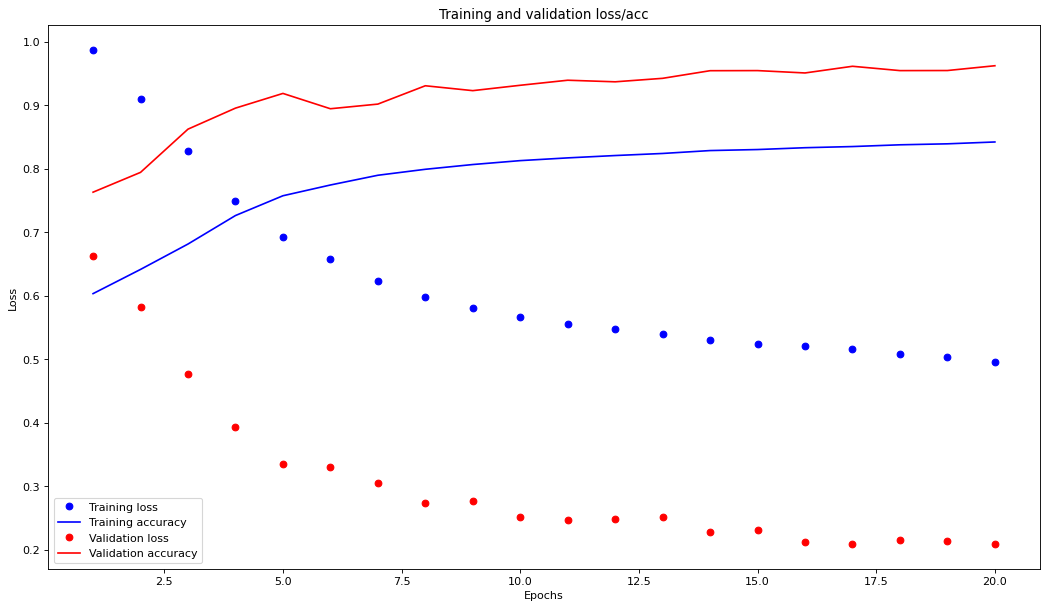

In [95]:
plot_history(history)

In [55]:
# save model 
model.save('deepfit_classifier_v2.h5')

In [109]:
model = tf.keras.models.load_model('deepfit_classifier_v2.h5')

# Random Testing

Estimated pose:
squats: 	0.0
lunges: 	0.0
bicep_curls: 	0.0
situps: 	0.9996424
pushups: 	0.0003575919
tricep_extensions: 	0.0
dumbbell_rows: 	3.197868e-37
jumping_jacks: 	4.460909e-34
dumbbell_shoulder_press: 	0.0
lateral_shoulder_raises: 	0.0

Prediction: situps
Actual Label :situps


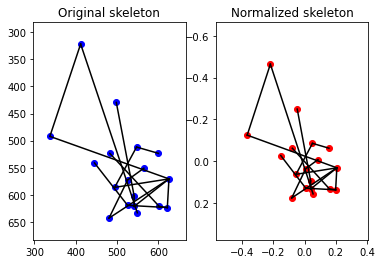

In [110]:
# Testing on single example
LABELS = list(d.keys())
ind = np.random.randint(0,70000)
X_sample = load_X('data/X_test.txt')[ind:2+ind]
X_sample_norm = norm_X(X_sample)
y_out = model.predict(X_sample_norm[0].reshape(1, 36))

print("Estimated pose:")
for idx in range(len(LABELS)):
    print(LABELS[idx] + ": \t" + str(y_out[0][idx]))
plot(X_sample[1])
print('\nPrediction: ',end='')
print(LABELS[np.argmax(y_out)])
print('Actual Label :', end='')
print(LABELS[int(load_Y('data/Y_test.txt')[ind])])

In [59]:
y_out.max()

0.8933624

# TF Lite Conversion

In [60]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('deepfit_classifier_v2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfeurobcy/assets


INFO:tensorflow:Assets written to: /tmp/tmpfeurobcy/assets


In [61]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='deepfit_classifier_v2.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Setup input
X_sample = load_X('data/X_test.txt')[0+1234:2+1234]
X_sample_norm = norm_X(X_sample)

In [62]:
input_details

[{'name': 'dense_4_input',
  'index': 0,
  'shape': array([ 1, 36], dtype=int32),
  'shape_signature': array([-1, 36], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [63]:

# Set up your input data.
input_data = np.array(X_sample_norm[0], np.float32).reshape(1,36)
input_data.shape

(1, 36)

In [65]:

# Invoke the model on the input data
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get the result 
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[7.26347983e-01 4.89446409e-02 1.69169411e-01 1.14792005e-04
  4.73633350e-04 9.77997558e-08 3.15452949e-03 4.39040922e-02
  2.26609875e-03 5.62471244e-03]]


In [66]:
output_data.max()

0.726348